In [1]:
import logging
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

import json
import geojson
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, LineString
import numpy as np
import pandas as pd
import geopandas as gpd

from external.pyFIS import pyFIS

%matplotlib inline

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
outputdir = Path('result')

# Get data from FIS
In this section we extract data from vaarweginformatie.nl using the pyFIS library. 

### Functions

In [4]:
node_start_columnname="StartJunctionId"
node_end_columnname="EndJunctionId"

In [5]:
# Splitting the closest line at given point

def nearest_line(point, lines):
    # Returns index of the closest line to the point
    # point: Shapely Point
    # lines: List of shapely Polylines
    # returns: index of nearest line, distance to nearest line
    d = np.full((len(lines)), fill_value=np.nan)
    for ii in range(len(lines)):
        d[ii] = point.distance(lines[ii])
    return np.argmin(d), np.min(d)


def all_points_in_radius(point, all_points, radius):
    # Find all points within radius
    # point: Shapely point
    # all_points: list of shapely points
    # returns: indices within radius
    d = np.full((len(all_points)), fill_value=np.nan)
    for ii in range(len(all_points)):
        d[ii] = point.distance(all_points[ii])
    return np.where(d < radius)[0]
    
def chainage_on_line(point, line):
    # Find chainage of line closest to point
    # point: Shapely Point
    # lines: Shapely Polylines
    return line.project(point)
    
def cut(line, chainage):
    # Cuts a line in two at a distance from its starting point
    # point: Shapely Polyline
    # chainage: distance along line
    
    # if 0 or longer than line, return line
    if chainage <= 0.0 or chainage >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == chainage:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > chainage:
            cp = line.interpolate(chainage)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [138]:
def update_id_in_dataFrame_at_chainage(df, name_nearest_line, chainage, node_ID, node_start_columnname="StartJunctionId", node_end_columnname="EndJunctionId"):
    """
    Split one LineString in the DataFrame at the given chainage. This removes
    the given line and adds two shorter new lines.
    
    """
    section_old = df.loc[name_nearest_line]
    split = cut(section_old.geometry, chainage)
    
    # Create new sections    
    section_new_1 = section_old.copy()
    section_new_2 = section_old.copy()

    section_new_1['geometry'] = split[0]
    section_new_2['geometry'] = split[1]

    section_new_1[node_end_columnname] = node_ID
    section_new_2[node_start_columnname] = node_ID
    
    # Set index
    section_new_1.name = f'{section_old.name}_A'
    section_new_2.name = f'{section_old.name}_B'
    
    # Update DataFrame
    df = df.drop(section_old.name, axis='index')
    df = df.append(section_new_1)
    df = df.append(section_new_2)

    return df

In [7]:
# Create file with fairway_nodes

def create_nodes_from_GeoDataFrame(all_nodes, fairway):
    """
    For each node, find all fairways that have this node as start or end point.
    Get the average location of these locations
    
    all_nodes: list of all nodes to find coordinate
    fairway: geodataframe containing linestrings with start/end point of nodes
    
    return: GeoSeries
    """
    
    fairway_nodes = {}
    for n in all_nodes:
        nn = fairway[fairway[node_start_columnname] == n]['geometry']
        points_start = [geom.coords[0] for geom in nn.geometry.values]
        nn = fairway[fairway[node_end_columnname] == n]['geometry']
        points_end = [geom.coords[-1] for geom in nn.geometry.values]

        points = MultiPoint(points_start + points_end)
        centroid = points.centroid

        fairway_nodes[n] = centroid
    fairway_nodes = gpd.GeoSeries(fairway_nodes)
    return fairway_nodes

In [8]:
def group_subobjects(objects, fieldname=None, type_selection='max'):
    """
    The netwerk only allows one object per location. For locks and bridges that means we limit the number of openings and locks to one (for now). 
    This script tries to take the most governing object. For bridges for example, the highest HeightClosed.
    
    TODO: Keep the count of number of locks
    
    """

    if fieldname is not None:
        # Remove nans
        objects = objects[~objects[fieldname].isna()]

    # Only keep opening with the maximum [fieldname]
    if type_selection=='max':
        ii = objects.groupby('Id')[fieldname].idxmax().values

        objects = objects.reindex(ii)
        objects = objects.set_index('Id')
    else:
        print('Unknown criteria')
        
        
    return objects



In [13]:
def get_subobjects(geotype1, list_of_ids, geotype2):
    """
    When the received that contains no data on how to join different datasets, this functions 
    can be ran to request the linked columns from the FIS-server.
    
    Very slow!
    
    geotype1: 'section'
    list_of_ids = [1,2,3]
    geotype2: 'maximumdimensions'
    """
    geotype2_ids = []
    for ii in tqdm(list_of_ids):
        subobjects = FIS.get_object_subobjects(geotype1, ii, geotype2)
        if len(subobjects) > 0:
            geotype2_ids.append(subobjects[0])
        else:
            geotype2_ids.append(None)
    return geotype2_ids

### FIS calls and processing

In [189]:
# Connect to FIS
FIS = pyFIS()

In [19]:
# Get all section (=vaarwegvakken) and properties from FIS
section = FIS.list_objects('section')   # TODO: Do not keep all columns
maximumdimensions = FIS.list_objects('maximumdimensions')
navigability = FIS.list_objects('navigability') 

maximumdimensions_columns = ['Id', 'GeneralDepth', 'GeneralLength', 'GeneralWidth', 'Note',
       'SeaFairingDepth', 'PushedLength',
       'PushedWidth', 'GeneralHeight', 'SeaFairingLength', 'SeaFairingWidth',
       'CoupledLength', 'CoupledWidth', 'PushedDepth', 'WidePushedDepth',
       'CoupledDepth', 'WidePushedLength', 'WidePushedWidth',
       'SeaFairingHeight']

navigability_columns = ['Id', 'Classification', 'Code', 'Description']

# Merge data of all three datasets

## This did not work out
## section = section.merge(maximumdimensions[maximumdimensions_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_maximumdimensions'))
## section = section.merge(navigability[navigability_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_navigability'))

section['maximumdimensions_id'] = get_subobjects('section', section.Id.values, 'maximumdimensions')
section['navigability_id'] = get_subobjects('section', section.Id.values, 'navigability')

section = section.merge(maximumdimensions[maximumdimensions_columns], left_on='maximumdimensions_id', right_on='Id', how='left', suffixes=('', '_maximumdimensions'))
section = section.merge(navigability[navigability_columns], left_on='navigability_id', right_on='Id', how='left', suffixes=('', '_navigability'))


# Add property length
# section['length'] = section.length.values

# Remove sections that do not have an ID as start or end point (in the selection polygon this is only the end of the Linge)
# Alternative: Make up new node names for these locations and also add those locations to the section_node table
section = section[~section[['StartJunctionId', 'EndJunctionId']].isna().any(axis=1)]

section = section.set_index('Id')
section_drop_columns = ['GeoGeneration', 'VinCode', 'Direction', 'RouteKmEnd', 'RouteKmBegin', 'TypeId', 'FairwayId', 
                        'RouteId', 'ForeignCode', 'maximumdimensions_id', 'navigability_id', 'Id_maximumdimensions', 'Note']
section = section.drop(section_drop_columns, axis=1)

section.to_file(outputdir / 'FIS_section.geojson', driver='GeoJSON')

In [20]:
# Get nodes from FIS --> Not using these, some strange inconsistencies with the sections...
# section_node = FIS.list_objects('sectionjunction').set_index('Id')

all_active_section_nodes = pd.Series(section[node_start_columnname].to_list() + section[node_end_columnname].to_list()).unique()
section_node = create_nodes_from_GeoDataFrame(all_active_section_nodes, section)

section_node.to_file(outputdir / 'FIS_section_node_manual.geojson', driver='GeoJSON')

In [21]:
# Get all bridges including openings
bridges = FIS.merge_geotypes('bridge', 'opening')

bridge_columns = ['Id', 'Name', 'NumberOfOpenings', 'HeightClosed', 'CanOpen', 'geometry']
bridges = bridges[bridge_columns]

bridges_grouped = group_subobjects(bridges, fieldname='HeightClosed')

bridges.to_file(outputdir / 'FIS_bridges.geojson', driver='GeoJSON')
bridges_grouped.to_file(outputdir / 'FIS_bridges_grouped.geojson', driver='GeoJSON')

In [23]:
# Get all locks including chambers
locks = FIS.merge_geotypes('lock', 'chamber')

locks_columns = ['Id', 'Name', 'geometry', 'NumberOfChambers', 'Length_chamber', 'Width_chamber']
locks = locks[locks_columns]

locks_grouped = group_subobjects(locks, fieldname='Id')

locks.to_file(outputdir / 'FIS_locks.geojson', driver='GeoJSON')
locks_grouped.to_file(outputdir / 'FIS_locks_grouped.geojson', driver='GeoJSON')

In [24]:
# Get all structures and their openings
structures = FIS.merge_geotypes('exceptionalnavigationalstructure', 'opening').set_index('Id')

# Rename type to readable names
structures['StructureType'] = structures['StructureType'].replace({
    'ADT': 'Aquaduct',
    'GDK': 'Grondduiker',
    'KBK': 'Noodkering',
    'KBL': 'Kabel',
    'KSS': 'Keersluis',
    'ONB': 'Onbekend??',
    'PIL': 'Pijpleiding',
    'STW': 'Stuw',
    'SVK': 'Stormvloedkering',
    'TNL': 'Tunnel',
    'TSB': 'Transportleiding',
    'VKW': 'Voormalig kunstwerk'
})

# Select only the blocking structures
structures = structures[structures['StructureType'].isin(['Keersluis', 'Stuw', 'Stormvloedkering'])]

# Only keep these columns for now
structures_columns = ['Name', 'geometry', 'StructureType']
structures = structures[structures_columns]

structures.to_file(outputdir / 'FIS_structures.geojson', driver='GeoJSON')

In [25]:
# Get all berths from FIS
berth = FIS.list_objects('berth').set_index('Id')

# Get only berths marked as 'Overnachtingshaven' (not loading/unloading)
berth = berth.loc[[('OVERNIGHT_ACCOMODATION' in c) for c in berth['Category']]]

# Convert polygons to points
berth['geometry'] = berth.geometry.centroid

berth_grouped = berth.dissolve(by=['RouteId', 'RouteKmBegin'], aggfunc={
    'GeoType': len, 
    'Length': np.max,
    'Width': np.max,
    'MaximalShipLength': np.max,
    'Name': 'first'
})

# Only keep these columns
berth_columns = ['Name', 'geometry', 'Length', 'Width', 'MaximalShipLength']
berth = berth[berth_columns]

berth_grouped = berth_grouped.rename({'GeoGeneration': 'NumberOfBerths'}, axis=1)
berth_grouped.index = [f'Berth{ii}' for ii in range(berth_grouped.shape[0])]
berth_grouped.geometry = berth_grouped.centroid

berth.to_file(outputdir / 'FIS_berth.geojson', driver='GeoJSON')
berth_grouped.to_file(outputdir / 'FIS_berth_grouped.geojson', driver='GeoJSON')

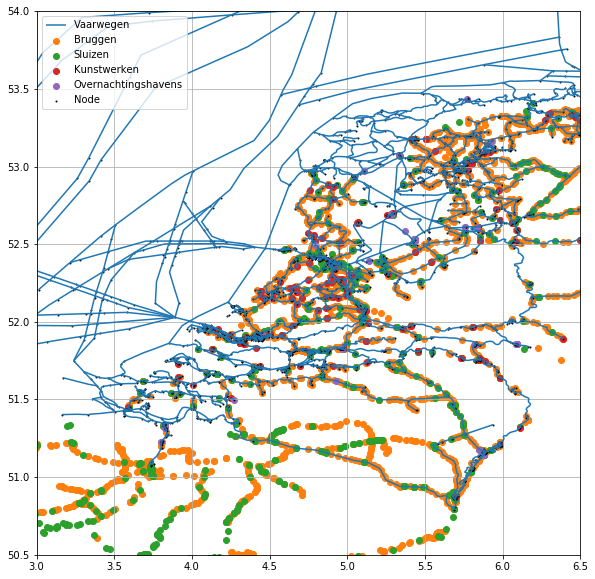

In [26]:
# Create plot to see what data we've loaded
f, ax  = plt.subplots(figsize=(14,10))
section.plot(color='C0', ax=ax, label='Vaarwegen')
bridges.plot(c='C1', ax=ax, label='Bruggen')
locks.plot(c='C2', ax=ax, label='Sluizen')
structures.plot(c='C3', ax=ax, label='Kunstwerken')
berth.plot(c='C4', ax=ax, label='Overnachtingshavens')
section_node.plot(color='k', ax=ax, markersize=1, label='Node')
ax.grid()
plt.legend(loc='upper left')

# Zoom to NL
plt.xlim(3, 6.5)
plt.ylim(50.5, 54);

plt.savefig(outputdir / 'FIS_NL.png', dpi=150, bbox_inches='tight')

### Expand with foreign Network

In [27]:
max_distance = 0.005

In [28]:
# Load Fairway for foreign network
fairway = FIS.list_objects('fairway').set_index('Id')
fairway.index = [f'F{f}' for f in fairway.index]             

# Remove Dutch network (nans)
fairway = fairway.loc[~fairway['ForeignCode'].isna()]

# Remove where FairwayNumber isna. This deletes some crappy data...
# fairway = fairway.loc[~fairway['FairwayNumber'].isna()]

fairway.loc[:, node_start_columnname] = None
fairway.loc[:, node_end_columnname] = None

# Add columns from other fairway objects
# --> Disabled, no additional data available for foreign network
# fairwayclassification = FIS.list_objects('fairwayclassification')
# fairwaydepth = FIS.list_objects('fairwaydepth') 
# fairwaystatus = FIS.list_objects('fairwaystatus') 

# fairwayclassification_columns = ['geometry', 'Type', 'TypeDescription']
# fairwaydepth_columns = ['geometry', 'MinimalDepthLowerLimit', 'MinimalDepthUpperLimit', 'ReferenceLevel']
# fairwaystatus_columns = ['geometry', 'TrajectCode', 'StatusCode', 'StatusDescription']


# fairway = fairway.merge(fairwayclassification[fairwayclassification_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwayclassification'))
# fairway = fairway.merge(fairwaydepth[fairwaydepth_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwaydepth'))
# fairway = fairway.merge(fairwaystatus[fairwaystatus_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwaystatus'))

# # Add Length column and filter very small branches
fairway['Length'] = fairway.geometry.length
fairway = fairway.loc[fairway['Length'] > max_distance]

In [29]:
# The following code will process the fairway files to find all intersection, construction 
# a network from it with ID's to all start and end point

generate_node_ID = (f'FN{ii}' for ii in range(999999) )

i_row = 0
while i_row < fairway.shape[0]: # Cannot loop over it, because it's changing shape when splitting
    ii = fairway.index[i_row]
    i_row += 1
    
    logger.debug(f'Fairway index {ii}')
    

    
    # Process both start and end point
    startpoint = Point(fairway.loc[ii].geometry.coords[0])
    endpoint = Point(fairway.loc[ii].geometry.coords[-1])
    
    for point, columnname in zip([startpoint, endpoint], 
                                 [node_start_columnname, node_end_columnname]):

        # Check if this is already has an id (than it is a split version of a branch we already did)
        if fairway.loc[ii][columnname] is not None:
            continue
        
        logger.debug(f'  {columnname[:-10]}')

        
        
        subset_fairways = fairway.drop(ii)  # All fairways except the current
        all_startpoints = [Point(geom.coords[0]) for geom in subset_fairways.geometry.values]
        all_endpoints = [Point(geom.coords[-1]) for geom in subset_fairways.geometry.values]
        all_points = (all_startpoints + all_endpoints)
        
        # Find all nearby points within radius
        i_nearby_points = all_points_in_radius(point, all_points, radius=max_distance)
        
        
        node_ID = next(generate_node_ID)
        
        snap_fairways = []
        
        for i_nearby_point in i_nearby_points:
            if i_nearby_point < subset_fairways.shape[0]:
                snap_to_fairway = subset_fairways.iloc[i_nearby_point].name
                snap_column = node_start_columnname
            else:
                snap_to_fairway = subset_fairways.iloc[i_nearby_point - subset_fairways.shape[0]].name
                snap_column = node_end_columnname
                
            snap_node_name = fairway.loc[snap_to_fairway, snap_column]
            if snap_node_name is not None:
                node_ID = snap_node_name  # Take name of snap_node instead
                
            snap_fairways.append(snap_to_fairway)  # Create list for later on
        
        logger.debug(f'    nearby points: {snap_fairways}')
        
        fairway.loc[ii, columnname] = node_ID
        
        # also remove the fairways which are snapping to nodes already
        subset_subset_fairways = subset_fairways.drop(snap_fairways)
            
        # Find all nearby lines
        i_nearest_line, distance_nearest_line = nearest_line(point, subset_subset_fairways.geometry.values)
        name_nearest_line = subset_subset_fairways.index[i_nearest_line]
        
        if distance_nearest_line > max_distance:
            logger.debug('    No nearby branch')
        else:
            logger.debug(f'    Nearest branch: {name_nearest_line}')
            # Find location of intersection and split geometry in two geometries
            geometry_nearest_line = fairway.loc[name_nearest_line].geometry
            chainage = chainage_on_line(point, geometry_nearest_line)
            
            clips_to_startpoint = chainage == 0
            clips_to_endpoint = abs(geometry_nearest_line.length - chainage) < 1e-10

            if clips_to_startpoint or clips_to_endpoint:
                logger.debug('      Already a node, so not splitting')
                continue
            else:
                logger.debug('      Splitting fairway at node')
                
                # Only continue to next index if we did not just delete a branch that we already processed. 
                if np.where(fairway.index == name_nearest_line)[0][0] < i_row: 
                    i_row += -1
                
                fairway = update_id_in_dataFrame_at_chainage(fairway, name_nearest_line, chainage, node_ID)

fairway['Length'] = fairway.geometry.length  # Update length for new branches
fairway.index = [f'F{ii}' for ii in fairway.index]
fairway.to_file(outputdir / 'FIS_fairway.geojson', driver='GeoJSON')

In [30]:
# Extract start/end-nodes from fairways
all_nodes = np.unique(fairway[node_start_columnname].to_list() + fairway[node_end_columnname].to_list())
fairway_nodes = create_nodes_from_GeoDataFrame(all_nodes, fairway)
fairway_nodes.to_file(outputdir / 'FIS_fairway_nodes.geojson', driver='GeoJSON')

### Merge inland and foreign network

In [31]:
# This code will link the network of section and fairway together by renaming nodes in fairway
rename = {}
for n, point in fairway_nodes.items():
    nearby_points = all_points_in_radius(point, section_node.geometry.values, radius=max_distance)
    if len(nearby_points) > 0:
        logger.debug(f'Found a match{n}, section_node.iloc[nearby_points].index')
        rename[n] = section_node.index[nearby_points[0]]  # Rename to first point
        
fairway[[node_start_columnname, node_end_columnname]] = fairway[[node_start_columnname, node_end_columnname]].replace(rename)

In [143]:
# Merge fairway and section

section_fairway = pd.concat([section, fairway], axis=0, sort=False)
section_fairway_node = pd.concat([section_node, fairway_nodes], axis=0, sort=False)

section_fairway.reset_index().to_file(outputdir / 'FIS_section_fairway.geojson', driver='GeoJSON')
section_fairway_node.to_file(outputdir / 'FIS_section_fairway_node.geojson', driver='GeoJSON')

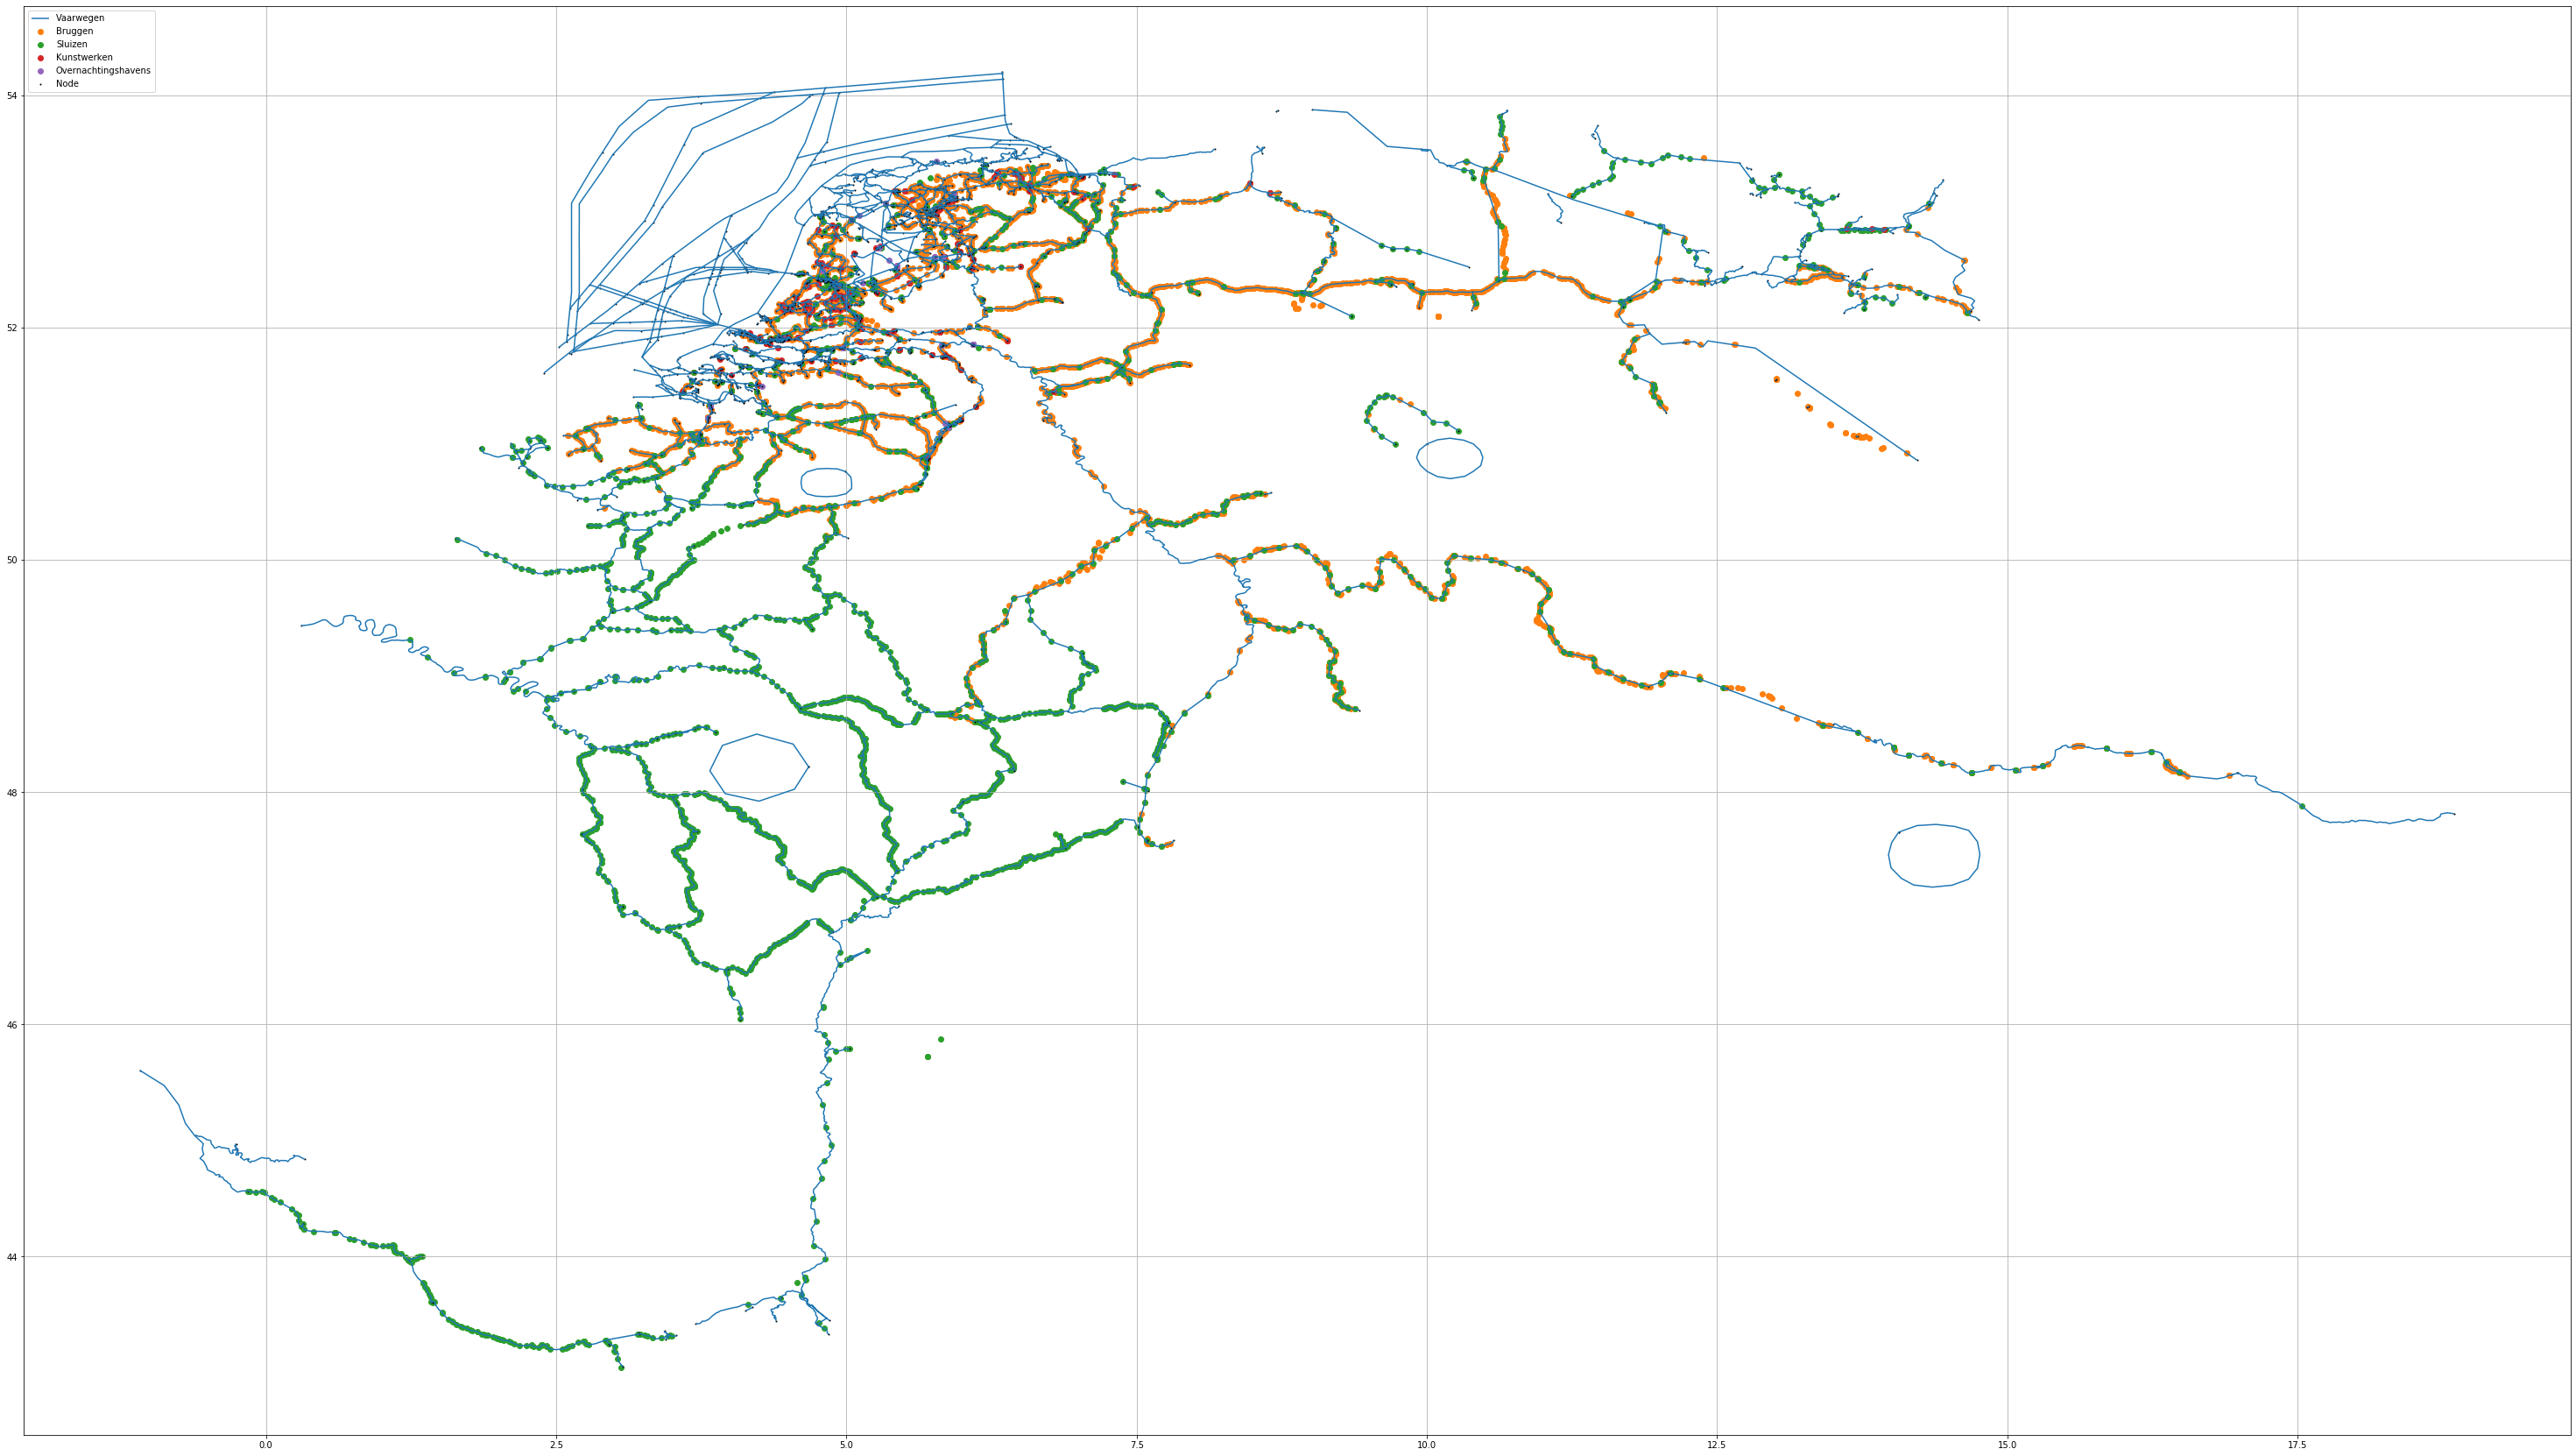

In [33]:
# Create plot to see what data we've loaded
f, ax  = plt.subplots(figsize=(70,30))
section_fairway.plot(color='C0', ax=ax, label='Vaarwegen')
bridges.plot(c='C1', ax=ax, label='Bruggen')
locks.plot(c='C2', ax=ax, label='Sluizen')
structures.plot(c='C3', ax=ax, label='Kunstwerken')
berth.plot(c='C4', ax=ax, label='Overnachtingshavens')
section_fairway_node.plot(color='k', ax=ax, markersize=1, label='Node')
ax.grid()
plt.legend(loc='upper left')

# plt.xlim(3, 8)
# plt.ylim(47, 54);
# plt.savefig()

plt.savefig(outputdir / 'FIS_Totaal.png', dpi=150, bbox_inches='tight')
plt.show()

### Split network at branches

In [139]:
def update_id_in_dataFrame_around_chainage(df, name_nearest_line, chainages, new_branch_names, new_node_names, geotype, node_start_columnname="StartJunctionId", node_end_columnname="EndJunctionId"):
    """
    Split one LineString in the DataFrame at the given chainages 
    This removes the given line and adds multiple shorter new lines. The middle section will get properties of the element
    
    
    """
    section_old = df.loc[name_nearest_line]
    
    # Delete old branch
    df = df.drop(name_nearest_line, axis='index')
        
    chainages = sorted(chainages)
    chainages = np.hstack((chainages[0], np.diff(chainages)))  # all but the first should be relative to the previous chainage
    splits = []
    remainder = section_old.geometry
    for chainage in chainages:
        s = cut(remainder, chainage)
        splits.append(s[0])
        remainder = s[1]
    splits.append(remainder)
        
    # Create new sections
    for ii, split in enumerate(splits):
        section_new = section_old.copy()
        section_new['geometry'] = split
        
        # Name the branch
        if geotype[ii] is not None:
            section_new['GeoType'] = geotype[ii]
        
        # Name the branch
        section_new.name = new_branch_names[ii]
        
               
        # Name the nodes
        if ii==0:
            section_new[node_end_columnname] = new_node_names[ii]
        elif ii==(len(splits)-1):
            section_new[node_start_columnname] = new_node_names[ii-1]
        else:
            section_new[node_start_columnname] = new_node_names[ii-1]
            section_new[node_end_columnname] = new_node_names[ii]
            
        # Update DataFrame
        df = df.append(section_new)
    
    return df

In [144]:
def split_lines_around_points(branches, objects, max_distance=0.002, prefix='B', geotype='bridge',
                              dx=0.0001,
                              node_start_columnname="StartJunctionId", node_end_columnname="EndJunctionId"):
    """
    branches: geodataframe of polylines
    objects: geodataframe of points where you want to polylines to split

    max_distance: maximum distance of point to line in order. When max_distance is exceeded, the point will be ignored
    prefix: the nodes will be split get a new of the index of 'bridge_selection' with this prefix

    node_start_columnname: in dataframe 'section_selection' name of start_node
    node_end_columnname: in dataframe 'section_selection' name of end_node

    # TODO: Convert to RD? or compute length in lat-lon for bridge/locks
    """

    branches_with_objects = branches.copy()

    for k, object in tqdm(objects.iterrows(), total=objects.shape[0]):

        b = object.geometry  # abreviate
        object_ID = f'{prefix}{k}'

        # Split closest section
        nearest_section, distance_to_nearest_section = nearest_line(b, branches_with_objects.geometry.values)
        name_nearest_section = branches_with_objects.index[nearest_section]

        geometry_nearest_line = branches_with_objects.loc[name_nearest_section].geometry

        if distance_to_nearest_section > max_distance:  # If distance (in degree) it too large, apparently it's not near a section
            logger.debug(f'Too far from river, ignoring point (name: "{object.Name}")')
            continue

        chainage = chainage_on_line(b, geometry_nearest_line)

        clips_to_startpoint = chainage - dx / 2 <= 0
        clips_to_endpoint = chainage + dx / 2 >= geometry_nearest_line.length
        if clips_to_startpoint:
            chainage_2 = dx
            if chainage_2 > geometry_nearest_line.length:
                # Rename branch to bridge
                branches_with_objects.loc[name_nearest_section, 'GeoType'] = geotype
                branches_with_objects.loc[name_nearest_section].name = object_ID
                continue
            chainages = [chainage_2]
            new_branch_names = [object_ID, name_nearest_section]
            geotype_names = [geotype, None]
            new_node_names = [f'{object_ID}_A']
        elif clips_to_endpoint:
            chainage_2 = geometry_nearest_line.length - dx
            if chainage_2 < 0:
                # Rename branch to bridge
                branches_with_objects.loc[name_nearest_section, 'GeoType'] = geotype
                branches_with_objects.loc[name_nearest_section].name = object_ID
                continue
            chainages = [chainage_2]
            new_branch_names = [name_nearest_section, object_ID]
            geotype_names = [None, geotype]
            new_node_names = [f'{object_ID}_A']
        else:
            chainage_1 = chainage - dx / 2
            chainage_2 = chainage + dx / 2
            chainages = [chainage_1, chainage_2]
            new_branch_names = [f'{name_nearest_section}_A', object_ID, f'{name_nearest_section}_B']
            geotype_names = [None, geotype, None]
            new_node_names = [f'{object_ID}_A', f'{object_ID}_B']

        branches_with_objects = update_id_in_dataFrame_around_chainage(branches_with_objects,
                                                                                name_nearest_section, chainages,
                                                                                new_branch_names, new_node_names,
                                                                                geotype=geotype_names)
    return branches_with_objects

In [145]:
def split_lines_at_points(branches, objects, max_distance=0.002, prefix='B',
                          node_start_columnname="StartJunctionId", node_end_columnname="EndJunctionId"):
    """
    section_selection: geodataframe of polylines
    bridges_selection: geodataframe of points where you want to polylines to split

    max_distance: maximum distance of point to line in order. When max_distance is exceeded, the point will be ignored
    prefix: the nodes will be split get a new of the index of 'bridge_selection' with this prefix

    node_start_columnname: in dataframe 'section_selection' name of start_node
    node_end_columnname: in dataframe 'section_selection' name of end_node

    """

    branches_with_objects = branches.copy()

    for k, object in tqdm(objects.iterrows(), total=objects.shape[0]):

        b = object.geometry  # abreviate
        object_ID = f'{prefix}{k}'

        # Split closest section
        nearest_section, distance_to_nearest_section = nearest_line(b, branches_with_objects.geometry.values)
        name_nearest_section = branches_with_objects.index[nearest_section]
        geometry_nearest_line = branches_with_objects.loc[name_nearest_section].geometry

        if distance_to_nearest_section > max_distance:  # If distance (in degree) it too large, apparently it's not near a section
            logger.debug(f'Too far from river, ignoring point (name: "{object.Name}")')
            continue

        chainage = chainage_on_line(b, geometry_nearest_line)
        clips_to_startpoint = chainage == 0
        clips_to_endpoint = abs(geometry_nearest_line.length - chainage) < 1e-10

        # Chainage already on a node, no need to split
        if clips_to_startpoint or clips_to_endpoint:

            # Replace name of node, with name of bridge
            if clips_to_startpoint:
                node_ID = branches_with_objects.loc[name_nearest_section, node_start_columnname]
            else:
                node_ID = branches_with_objects.loc[name_nearest_section, node_end_columnname]

            logger.debug(f'Renaming node {node_ID} to point {object_ID} (name: "{object.Name}")')
            branches_with_objects[[node_start_columnname, node_end_columnname]] = \
            branches_with_objects[[node_start_columnname, node_end_columnname]].replace({node_ID: object_ID})
            continue

        branches_with_objects = update_id_in_dataFrame_at_chainage(branches_with_objects,
                                                                            name_nearest_section, chainage, object_ID)

    return branches_with_objects

In [146]:
section_fairway = split_lines_around_points(section_fairway, bridges_grouped, max_distance=0.002, prefix='B', geotype='bridge', dx=0.0001)
section_fairway = split_lines_around_points(section_fairway, locks_grouped, max_distance=0.002, prefix='L', geotype='lock', dx=0.0004)
section_fairway = split_lines_around_points(section_fairway, structures, max_distance=0.002, prefix='S', geotype='structure', dx=0.0001)

In [148]:
section_fairway = split_lines_at_points(section_fairway, berth_grouped, max_distance=0.002, prefix='')

In [150]:
all_nodes = pd.Series(section_fairway[node_start_columnname].to_list() + section_fairway[node_end_columnname].to_list()).unique()
section_fairway_node = create_nodes_from_GeoDataFrame(all_nodes, section_fairway)

In [151]:
section_fairway.to_file(outputdir / 'network_section_fairway.geojson', driver='GeoJSON')
section_fairway_node.to_file(outputdir / 'network_section_fairway_node.geojson', driver='GeoJSON')

# Build network
Based on the geometry we can now define a more abstract graph. A graph representation is similar to a subway map. It does not store the exact locations but it does store the topological relations between all the locations. 

In [152]:
def build_network(section_selection_with_bridges_with_locks):
    section_selection_with_bridges_with_locks['length'] = section_selection_with_bridges_with_locks.length.values
    section_selection_with_bridges_with_locks['Wkt'] = [a.wkt for a in section_selection_with_bridges_with_locks.geometry]
    section_selection_with_bridges_with_locks = section_selection_with_bridges_with_locks.drop('geometry', axis=1)
    
    network = nx.from_pandas_edgelist(section_selection_with_bridges_with_locks, 'StartJunctionId', 'EndJunctionId', edge_attr=True)
    
    return network

In [154]:
# Create networkx
network_includingHanging = build_network(section_fairway)

In [221]:
# Only keep the largest component (subgraph) and remove all disconnected subgraphs.
largest_component = max(nx.connected_components(network_includingHanging), key=len)
network = network.subgraph(largest_component).copy()

In [155]:
# Add node properties
for n in network.nodes:
    network.nodes[n]['X'] = section_fairway_node.loc[n].x
    network.nodes[n]['Y'] = section_fairway_node.loc[n].y
    network.nodes[n]['geometry'] = Point(section_fairway_node.loc[n].x, section_fairway_node.loc[n].y)

In [222]:
# Some stats
print(nx.classes.function.info(network))

Name: 
Type: Graph
Number of nodes: 14422
Number of edges: 14874
Average degree:   2.0627


In [156]:
nx.write_yaml(network, outputdir / 'export_full_network.yaml')

In [169]:
with open(outputdir / 'export_full_network.json', 'w') as fout:
    json.dump(nx.readwrite.json_graph.node_link_data(network), fout)

(-2.095431542817713, 19.857475915082013, 42.48404645014981, 54.77349067264228)

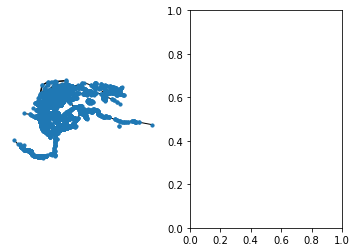

In [194]:
# this is the subway version of the corridor
fig, axes = plt.subplots(ncols=2)

spatial_pos = {
    k: (v['X'], v['Y']) 
    for k, v 
    in network.nodes.items()
}
nx.draw(
    network, 
    pos=spatial_pos, 
    node_size=10,
    ax=axes[0]
)
axes[0].axis('equal')

# pos = nx.spring_layout(network, pos=spatial_pos, weight='Length', iterations=50)

# nx.draw(
#     network, 
#     pos=pos, 
#     node_size=10,
#     ax=axes[1]
# )
# axes[1].axis('equal')
# fig